# Analysis of BIODYN-100 BOM
Python 3.10.16

In [14]:
# Install libraries
%pip install pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Read Tidy BOM
import pandas as pd
bom_file_name = "data/BIODYN-100 v58 BOM Tidy.csv"

df = pd.read_csv(bom_file_name, sep=";")
df.head(2)

,Part,Value,Device,Footprint Name,Detailed Description,Link,Manuf Part Number,Datasheet URL,Description,Manufacturer,DigiKey Part Number,Pricing,Stock
0,EMG1:D1,1N4148DO35-10,1N4148DO35-10,DO35-10,DIODE,https://www.digikey.ca/en/products/detail/onse...,1N4148,https://www.mccsemi.com/pdf/Products/1N4148WX(...,DIODE STANDARD 75V 150MA SOD323,MCC (Micro Commercial Components),1N4148WXTPMSCT-ND,"[{'break_quantity': 1, 'total_price': 0.1, 'un...",1145155.0
1,EMG1:D2,1N4148DO35-10,1N4148DO35-10,DO35-10,DIODE,https://www.digikey.ca/en/products/detail/onse...,1N4148,https://www.mccsemi.com/pdf/Products/1N4148WX(...,DIODE STANDARD 75V 150MA SOD323,MCC (Micro Commercial Components),1N4148WXTPMSCT-ND,"[{'break_quantity': 1, 'total_price': 0.1, 'un...",1145155.0


# Calculate Pricing

In [16]:
df['Count'] = 1
agg_funcs = {
	'Count': 'sum', 
	'Manuf Part Number': 'first', 
	'Description': 'first', 
	'DigiKey Part Number': 'first', 
	'Link': 'first',
	'Pricing': 'first'
	}
df_by_device = df.groupby(df['Device']).aggregate(agg_funcs)

df_by_device.head(2)

,Count,Manuf Part Number,Description,DigiKey Part Number,Link,Pricing
Device,,,,,,
1N4148DO35-10,2,1N4148,DIODE STANDARD 75V 150MA SOD323,1N4148WXTPMSCT-ND,https://www.digikey.ca/en/products/detail/onse...,"[{'break_quantity': 1, 'total_price': 0.1, 'un..."
885012005024_6.3V(DC),5,885012005024,CAP CER 6.8PF 16V C0G/NP0 0402,732-7440-1-ND,https://www.digikey.ca/en/products/detail/würt...,"[{'break_quantity': 1, 'total_price': 0.1, 'un..."


In [17]:
import json

def price_for_boards(n: int) -> float:
	total = 0
	for row in df_by_device.itertuples():
		pricestr = getattr(row, 'Pricing')
		device = row.Index
		if pricestr is None or pricestr == '':
			if "BATTERYLIPO-TABS" != device:
				print("NO PRICE FOR", device)
			continue
		pricing = json.loads(pricestr.replace("'", '"'))
		count = getattr(row, 'Count')
		biggest = None
		for p in pricing:
			if biggest is None or (p['break_quantity'] > biggest['break_quantity'] and p['break_quantity'] <= n * count):
				biggest = p
		dev_sum = biggest['unit_price'] * count * n
		total += dev_sum
	return total

def avg_price_for_boards(n: int) -> float:
	return price_for_boards(n) / n

price_for_boards(1)

df_price_for_boards = pd.DataFrame([i for i in range(1, 500)], columns=['Boards'])
df_price_for_boards["Price (USD)"] = df_price_for_boards['Boards'].apply(price_for_boards)
df_price_for_boards["Average Price (USD)"] = df_price_for_boards['Boards'].apply(avg_price_for_boards)

df_price_for_boards.head(4)

,Boards,Price (USD),Average Price (USD)
0,1,60.910,60.910
1,2,118.416,59.208
2,3,176.082,58.694
3,4,228.740,57.185


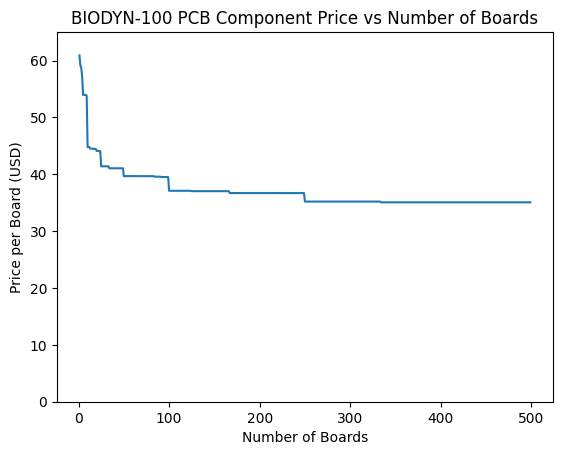

In [18]:
import matplotlib.pyplot as plt

plt.xlabel('Number of Boards')
plt.ylabel('Price per Board (USD)')
plt.title('BIODYN-100 PCB Component Price vs Number of Boards')
plt.ylim(0, 65)
plt.plot(df_price_for_boards['Boards'], df_price_for_boards['Average Price (USD)'])


Copyright © 2025 Callum Mackenzie 